In [1]:
import pandas as pd
import numpy as np
import eikon as ek
import sys
import config
ek.set_app_key(config.eikon_key)
#import DatastreamDSWS as DSWS
#ds = DSWS.Datastream(username = 'JGarden1@lidoadvisors.com', password= 'Welcome2')
from datetime import timedelta
import datetime

from scipy.optimize import minimize
from arch import arch_model

from tqdm import tqdm
TOLERANCE = 1e-15
import warnings
warnings.filterwarnings("ignore")
import cufflinks as cf
#import configparser as cp
cf.set_config_file(offline = True)
import cvxpy as cp

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#from scipy.optimize import OptimizeWarning
#warnings.simplefilter(action='ignore', category=OptimizeWarning)

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import chart_studio
from chart_studio.plotly import plot, iplot
import chart_studio.plotly as py
from PIL import Image as im
#import Lido_funcs3 as lf
import time
from sklearn.linear_model import LinearRegression

import IPython.display
from IPython.display import Image

import chart_studio.tools as tls

import plotly.io as pio

import plotly.figure_factory as ff

from plotly.subplots import make_subplots
import scipy.stats as st
from tqdm import tqdm
import random

In [2]:
###Date setup
mar = []
jun = []
sept = []
dec = []

for i in range(2015, 2021):
    dt_3 = datetime.date(i, 3, 15)
    if dt_3.isoweekday() == 6:
        dt_3 = datetime.date(i, 3, 17)
    elif dt_3.isoweekday() == 7:
        dt_3 = datetime.date(i, 3, 16)
    st_dt_3 = dt_3.strftime("%Y-%m-%d")
    mar.append(st_dt_3)
    dt_6 = datetime.date(i, 6, 15)
    if dt_6.isoweekday() == 6:
        dt_6 = datetime.date(i, 6, 17)
    elif dt_6.isoweekday() == 7:
        dt_6 = datetime.date(i, 6, 16)
    st_dt_6 = dt_6.strftime("%Y-%m-%d")
    jun.append(st_dt_6)
    dt_9 = datetime.date(i, 9, 15)
    if dt_9.isoweekday() == 6:
        dt_9 = datetime.date(i, 9, 17)
    elif dt_9.isoweekday() == 7:
        dt_9 = datetime.date(i, 9, 16)
    st_dt_9 = dt_9.strftime("%Y-%m-%d")
    sept.append(st_dt_9)
    dt_12 = datetime.date(i, 12, 15)
    if dt_12.isoweekday() == 6:
        dt_12 = datetime.date(i, 12, 17)
    elif dt_12.isoweekday() == 7:
        dt_12 = datetime.date(i, 12, 16)
    st_dt_12 = dt_12.strftime("%Y-%m-%d")
    dec.append(st_dt_12)
    

dates = []
for i in range(0, len(mar)):
    dates.append(mar[i])
    dates.append(jun[i])
    dates.append(sept[i])
    dates.append(dec[i])
    


In [3]:
def get_asset_prices(asset_list, year_list):
    '''This function takes in a list of RIC codes and years returns daily CLOSE prices for these years requires a connection to Refinitiv Eikon'''
    
    month = [3, 6, 9, 12] ###Call data quarterly
    day = [31, 30, 30, 31]
    year = year_list
    df_prices = pd.DataFrame()
    for y in year:
        for m in tqdm(range(0, len(month))):
            dt = datetime.datetime(y, month[m], day[m])
            e_date = dt.strftime('%Y-%m-%d')
            edt = dt - timedelta(days=95)#### 95 days ensures that the request covers a whole quarter duplicates are droped after data is receieved
            s_date = edt.strftime('%Y-%m-%d')
            df = ek.get_timeseries(asset_list, fields = 'CLOSE', start_date = s_date, end_date = e_date, interval = 'daily')
            time.sleep(3) ### Sleep for three seconds between calls reduces timeouts 
            df_prices = pd.concat([df_prices, df]).drop_duplicates()
            df_prices.sort_index()
        
    df_prices.to_csv('Section_2_Prices.csv')    
    return df_prices

In [4]:
###PCA Selection

def pca_func(df_px):
    '''This function takes in a datafram of asset prices, returns a the PCA model with the fewest componants needed to explain 95% of variance + SCREE Plot'''
    df_rets = df_px.pct_change()
    df_rets = df_rets.replace(np.nan, 0)
    test_pca = PCA(n_components= len(df_px.columns)).fit(df_rets)
    vari = test_pca.explained_variance_ratio_
    vari = [round(i,6) for i in vari]
    cum_var = [sum(vari[0:i]) for i in range(0, len(vari))]
    x_lst = ['PC_{}'.format(i) for i in range(1,21)]
    fig = go.Figure(go.Bar(x = x_lst, y = vari,  marker_color='#005A9C', name = 'Variance Explained '))
    fig.add_trace(go.Scatter(x = x_lst, y = cum_var, mode = 'markers+lines', marker_color='#EF3E42', name = 'Cumulative Variance Explained' ))
    fig.update_yaxes(tickformat=".2%", range=[0,1])
    fig.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
                           plot_bgcolor='white' , height = 600, width = 1200, title_text='Variance Explained (SCREE Plot)', title_x=0.5)
    cands = [i for i, x in enumerate(cum_var) if x>0.95]
    n_pca = cands[0] + 1
    pca = PCA(n_components= n_pca).fit(df_rets)
    
    fig.show()
    return n_pca
    

In [5]:
def port_vol(weights, covar):
    weights = np.array(weights)
    var = np.dot(np.dot(weights.T, covar), weights)
    vol = np.sqrt(var)
    return vol

def risk_cont (weights, covar):
    weights = np.array(weights)
    sig = port_vol(weights, covar)
    MCR = np.dot(covar, weights)/sig
    RC = (MCR * weights)
    return RC


def _risk_budget_objective_error(weights, args):
    covar = args[0]
    assets_risk_budget = args[1]
    weights = weights
    sig = port_vol(weights, covar)
    risk_conts = risk_cont(weights, covar)
    risk_tgts = np.asmatrix(np.multiply(sig, assets_risk_budget))
    error = sum(np.square(risk_conts -risk_tgts.T))[0,0]*10000
    return error
                

def get_weights(cov, risk_tgts, w0):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    
    optimize_result = minimize(fun=_risk_budget_objective_error,
                              x0=w0,
                              args=[cov, risk_tgts],
                              method='SLSQP',
                              constraints=constraints,
                              tol=TOLERANCE,
                              options={ 'maxiter' : 10000,'disp': True,  'ftol': 1e-15})
    weights = optimize_result.x
    return weights

In [6]:
def run_day(df_px, s_date, n_pca):
    assets = df_px
    random.seed(0)

    asset_rets = assets.pct_change().dropna()
    asset_rets = asset_rets.sort_index()
    lb_date = s_date - timedelta(days = ((365)))
    lb_date = datetime.datetime.strftime(lb_date, '%Y-%m-%d')
    s_date = datetime.datetime.strftime(s_date, '%Y-%m-%d')
    subset = asset_rets.loc[lb_date:s_date]
    pca = PCA(n_components = 8).fit(subset)
    comps = pca.transform(subset)
    alpha = pca.components_
    var_rat = pca.explained_variance_ratio_

    PC_s = [comps[:,0]*100, comps[:,1]*100, comps[:,2]*100, comps[:,3]*100, comps[:,4]*100, comps[:,5]*100, comps[:,6]*100, comps[:,7]*100]
    delta = []
    for p in PC_s:
        p = p.copy(order = 'C')
        x = arch_model(p, mean ='Zero', vol = 'GARCH', p = 1, q=1, rescale = False).fit(disp = 'off')
        y = x.forecast(horizon = 30, method = 'bootstrap')
        z = y.variance.dropna()
        delta.append(z['h.30'].iloc[-1])
    delta = np.diag(delta)/10000
    v = np.dot(np.dot(alpha.T, delta), alpha)
    covar = pd.DataFrame(v, columns = ['SHY.O','GOVT.K','LQD','MBB.O', 'JNK', 'IVV','IJH', 'IJR', 'EFA', 'EEM', 'IAU', 'GSG'], 
                         index  = ['SHY.O','GOVT.K','LQD','MBB.O', 'JNK', 'IVV','IJH', 'IJR', 'EFA', 'EEM', 'IAU', 'GSG'])
    
    start = [1/len(covar) for i in range(0, len(covar))]
    rpar = get_weights(covar, start,  start)
    
    wghts = []
    asset = []
    for i in tqdm(range(0, len(rpar))):
        x = assets.columns[i]
        y = rpar[i]
        wghts.append(round(y,8))
        asset.append(x)
    
    rpar_vol = port_vol(rpar, covar)
    ctr = risk_cont (rpar, covar)
    
    #print('Portfolio Weights:{}'.format(wghts))
    #print()
    #print('Volatility: {}'.format(round(rpar_vol,2)*100))
    #print([round(c,2)*100 for c in ctr])
    
    res = pd.DataFrame(wghts).T
    res.columns = asset
    res = res.rename(columns = {'SHY.O':'CASH','GOVT.K':'US TREAS','LQD': 'IG CORP','MBB.O': 'MBS', 'JNK':'HIGH_YLD',
                                'IVV':'LC','IJH':'MC', 'IJR':'SC','EFA':'Eur/Aust/F.East', 'EEM':'Emerging', 'IAU':'GOLD', 'GSG':'COMM'})
    
    print((covar['IVV'].loc['IVV']*252)**0.5)
    
    return res

In [7]:
def run_bt(dates, df_px, pca):
    bets = pd.DataFrame()
    for d in dates[3:]:
        d= datetime.datetime.strptime(d, '%Y-%m-%d')
        x = run_day(df_px, d, pca)
        bets = pd.concat([bets,x])
    bets['Dates'] = dates[3:]
    bets = bets.set_index('Dates')
    performance_df = df_px.loc['2015-12-15':]
    performance_df= performance_df.sort_index()
    performance_df = performance_df.rename(columns = {'SHY.O':'CASH','GOVT.K':'US TREAS','LQD': 'IG CORP','MBB.O': 'MBS', 'JNK':'HIGH_YLD',
                                'IVV':'LC','IJH':'MC', 'IJR':'SC','EFA':'Eur/Aust/F.East', 'EEM':'Emerging', 'IAU':'GOLD', 'GSG':'COMM'})
    

    dates = dates[3:]
    dates_2 = dates[1:]

    dates_2.append('2020-12-31')

    values = []
    date = []

    cur_value = 1000000
    classes = list(performance_df.columns)
    
    for i in range(0, len(dates)):
        x = performance_df.loc[dates[i]:dates_2[i]]
        allocation_val = bets.loc[dates[i]] * cur_value
        shares = [k/z for k,z in zip(allocation_val,list(x.iloc[0]))]
        for d in x.index:
            px = x.loc[d].to_numpy()
            shares = np.asarray(shares)
            val = np.dot(px,shares)
            values.append(val)
            cur_value = val
            date.append(d)
            
    ####60/40port
    alloc_6040 =[0* 1000000, 1 * 1000000]
    px_stock =performance_df['LC'].iloc[0]
    px_bnd = performance_df['IG CORP'].iloc[0]
    shares = [alloc_6040[0]/px_stock, alloc_6040[1]/px_bnd]
    df_6040 = performance_df.filter(['LC', 'IG CORP'])
    val_60_40 = [np.dot(df_6040.iloc[i], shares) for i in range(0, len(df_6040))]
            
    
    portfolio_df = pd.DataFrame({'Date':date, 'Value':values,})
    portfolio_df = portfolio_df.drop_duplicates(subset = 'Date', keep = 'last')
    
    portfolio_df['Bond'] = val_60_40
    portfolio_df = portfolio_df.set_index('Date')
    portfolio_df['Port'] = portfolio_df['Value']/portfolio_df['Value'].iloc[0]
    portfolio_df['Bond_Port'] = portfolio_df['Bond']/portfolio_df['Bond'].iloc[0]
    return portfolio_df, bets
            
                          


In [8]:
def alloc_over_time(bets):    
    colors = ['#9A3324', '#75988d', '#00B2A9', '#702082', '#CFC096', '#989C97', '#655A52', '#FFCB05', '#00274C', '#EF3E42', '#552583', '#FDB927', '#000000']
    cols = list(bets.columns)
    fig_alloc = go.Figure()
    for i in range(0, len(cols)):
        fig_alloc.add_trace(go.Scatter(
        x= bets.index,
        y = bets[cols[i]],
        line=dict(width=0.5, color=colors[i]),
        name = 'Allocation to {}'.format(cols[i]),
        stackgroup = 'one'))


    fig_alloc.update_yaxes(tickformat=".2%")




    fig_alloc.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
                        plot_bgcolor='white' , height = 800, width = 1200, title_text='Change in Allocation Over Time', title_x=0.5)


    return fig_alloc.show()

In [12]:
def perf_plot(port_df):
    acwi = ek.get_timeseries('ACWI.O', fields = 'CLOSE', start_date = '2015-12-15', end_date = '2020-12-31',interval = 'daily')
    acwi['ACWI'] = acwi['CLOSE']/acwi['CLOSE'].iloc[0]
    ac_perf = list(acwi['ACWI'])
    
    funds = port_df
    funds = funds.reset_index()
    portfolios = funds.filter(['Date', 'Port', 'Bond_Port'])
    portfolios['ACWI'] = ac_perf
    fig_perf = go.Figure()

    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Date'],
        y = portfolios['Port'],
        name = 'Risk Parity Portfolio',
        line = {'color': '#9A3324'}))



    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Date'],
        y = portfolios['ACWI'],
        name = 'All Country World Index',
        line = {'color': '#FFCB05'}))

    fig_perf.add_trace(
        go.Scatter(
        x = portfolios['Date'],
        y = portfolios['Bond_Port'],
        name = 'Bond portfolio',
        line = {'color': '#00274C'}))

    fig_perf.update_yaxes(tickformat=".2%", title = 'Portfolio Return')




    fig_perf.update_layout(legend=dict(orientation='h',yanchor='top',xanchor='center',y=-0.05, x=0.5), paper_bgcolor='white',
        plot_bgcolor='white' , height = 800, width = 1200, title_text='Performance', title_x=0.5)
    
    daily_rp = portfolios['Port'].pct_change().dropna()
    daily_6040 = portfolios['Bond_Port'].pct_change().dropna()
    daily_acwi = portfolios['ACWI'].pct_change().dropna()
    
    mu_a = daily_rp.mean() *252
    mu_b = daily_6040.mean() * 252
    mu_c = daily_acwi.mean() * 252
    
    sig_a = daily_rp.std() * (252**0.5)
    sig_b = daily_6040.std() * (252**0.5)
    sig_c = daily_acwi.std() * (252**0.5)

    active_sharpe = (mu_a)/sig_a
    bh_sharpe = (mu_b)/sig_b
    ac_sharpe = (mu_c)/sig_c
    
    
    
    print('RPAR Portfolio Sharpe: {:.2f}'.format(active_sharpe))
    print('Bond Sharpe: {:.2f}'.format(bh_sharpe))
    print('MSCI All Countery Index: {:.2f}'.format(ac_sharpe))
    print(sig_a, sig_b)

    return fig_perf.show()


In [13]:

def MADS_MS2_A(dates):
    #spares = ['SHY.O','LQD','TLT.O', 'IEF.O', 'JNK', 'BIL', 'TIP']
    #asset_list = ['SHY.O','GOVT.K','LQD','MBB.O', 'JNK', 'IVV','IJH', 'IJR', 'EFA', 'EEM', 'IAU', 'GSG']
    #year = [2015, 2016, 2017, 2018, 2019, 2020]
    #df_px = get_asset_prices(asset_list, year)
    df_px = pd.read_csv('Section_2_Prices.csv', index_col = 'Date')
    pca = pca_func(df_px)
    port_df, bets = run_bt(dates, df_px, pca)
    perf_plot(port_df)
    alloc_over_time(bets)
    
    return pca, port_df, bets
    


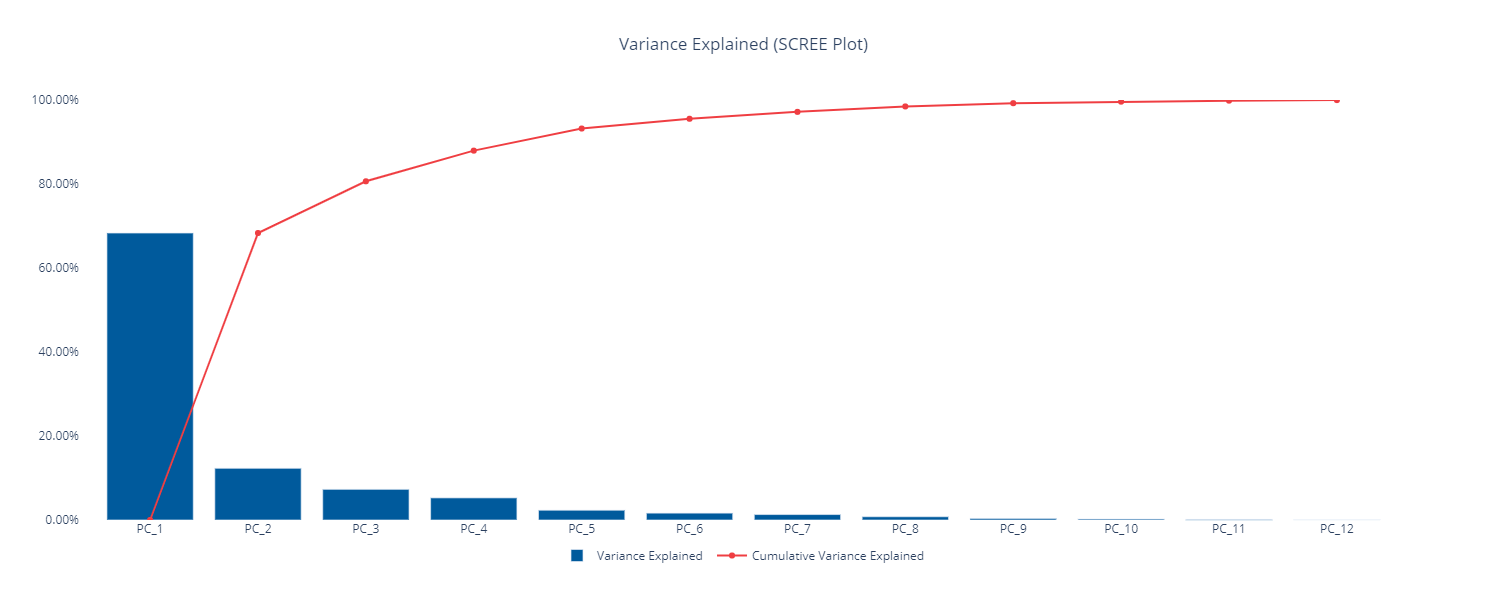

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.43it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.2964138937403736e-16
            Iterations: 10
            Function evaluations: 140
            Gradient evaluations: 10
0.154311656111034



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 667.25it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.8713228395201354e-19
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 12
0.17821744189068214



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.46it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1425240154390948e-21
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
0.16387739313343497



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 710.78it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6118857214299397e-16
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.15425461755165784



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 707.79it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.692990067833767e-16
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.13396712514623013



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.43it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4882580339648217e-18
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.10227369728489132



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 707.81it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.0088473659541815e-21
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
0.07134359494489116



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 707.82it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6506968521258211e-19
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
0.0720684139597576



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 705.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.15747638754221e-20
            Iterations: 10
            Function evaluations: 140
            Gradient evaluations: 10
0.06706728647755711



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 706.45it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.124051745056653e-20
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 12
0.10184067984760763



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.41it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.16072042830971e-19
            Iterations: 12
            Function evaluations: 168
            Gradient evaluations: 12
0.12393338013650186



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 751.98it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.5379843575156925e-17
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
0.12192972231895194



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 707.62it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.053673624508685e-17
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
0.17637562031194498



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 705.61it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.483463932041998e-16
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.1545968023825903



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 706.40it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.881314098076962e-16
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.1567598657719475



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.45it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.192376837169197e-19
            Iterations: 9
            Function evaluations: 126
            Gradient evaluations: 9
0.17196587230719845



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 668.53it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.08733517720692e-19
            Iterations: 8
            Function evaluations: 113
            Gradient evaluations: 8
0.1328218618979194



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 633.22it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.517838168708247e-17
            Iterations: 6
            Function evaluations: 84
            Gradient evaluations: 6
1.3528967233200022



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 707.72it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.89871387447884e-19
            Iterations: 7
            Function evaluations: 98
            Gradient evaluations: 7
0.49445362781371055



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 708.37it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1181628381538535e-18
            Iterations: 8
            Function evaluations: 112
            Gradient evaluations: 8
0.2796013848874818



100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 705.58it/s]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.508393687986226e-18
            Iterations: 8
            Function evaluations: 112
            Gradient evaluations: 8
0.3125503208122249


RPAR Portfolio Sharpe: 0.42
Bond Sharpe: 0.48
MSCI All Countery Index: 0.61
0.03136419013433158 0.08628042558574954


In [14]:
pca, port_df, bets = MADS_MS2_A(dates)